This is the exact solution of the adviction equation in 1D with 1 wave going from left to right at a constant speed.

In [180]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from IPython.display import display, clear_output # this is for plotting animations
import sys
init_printing()

The equation we are trying to model is the advection equation:

$$q_x + \hat{u}q_t = 0$$

making of the initial data

Text(0.5, 1.0, 'Initial Conditions')

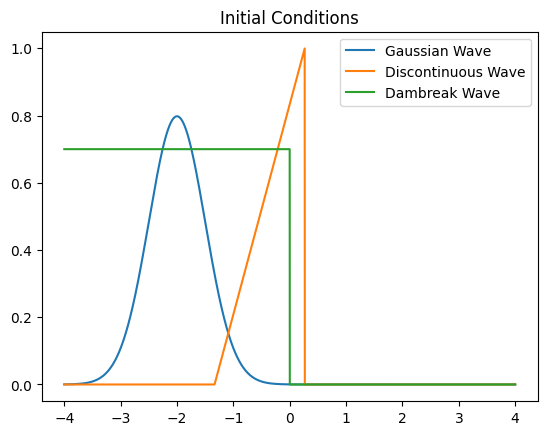

In [181]:
# we have x on an interval [0,2], t = [0,1] and we timestep each in 1001 steps, which gives us 1000 intervals
x_points = 10000
timesteps = 6000
x_length = 8
t_length = 2
higher_dam_break_v = 0.7
x = np.linspace(-4,4,x_points+1)
# defining initial for a discontinuous wave
initial_dis_wave = np.zeros(x_points+1) 
for i in range(0,x_points//5):
    initial_dis_wave[int(x_points/3)+i] = i*(5/x_points)
# defining initial for a gaussian wave 
sigma = 1/2
mu = -2
initial_gaus_wave = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

# defining initial for a dambreak wave 
initial_dam_break = np.zeros(x_points+1)
for i in range(0,int(x_points//2)):
    initial_dam_break[i] = higher_dam_break_v    

#defining time interval and speed (u hat)
t_array = np.linspace(0,t_length,timesteps)
u_hat = 1.5 # this is u hat

#plot initial waves
plt.plot(x,initial_gaus_wave, label = 'Gaussian Wave')
plt.plot(x,initial_dis_wave, label = 'Discontinuous Wave')
plt.plot(x,initial_dam_break, label = 'Dambreak Wave')
plt.legend()
plt.title('Initial Conditions')

propergation of each wave with:

$$q(x,t) = \mathring{q}(x-\hat{u}t)$$

In [182]:
def calculate_exact_state_1wave(initial_values, x, t, u, min_interval_value, step_size, dam_break):
    # defining the exact solution for a single wave
    temp = x - u*t
    if temp < min_interval_value:
        if dam_break == True:
            return higher_dam_break_v 
        else:
            return 0  # setting 0 inflow on the left boundary
    elif temp < 0:
        # distance from the left boundary, calculated by negative boundery condition - negative value. 
        distance_from_left_boundary = abs(min_interval_value-temp)
        index = int(distance_from_left_boundary/step_size)
        return initial_values[index]
    else:
        index = int((abs(min_interval_value) + temp)/step_size)
        return initial_values[index]

Plotting an animation with respect to time for each of the three wave types

In [183]:
# write 0 below for discontinuous wave, 1 for gaussian wave and 2 for dambreak wave
current_wave = 2 
waves = [initial_dis_wave, initial_gaus_wave, initial_dam_break]

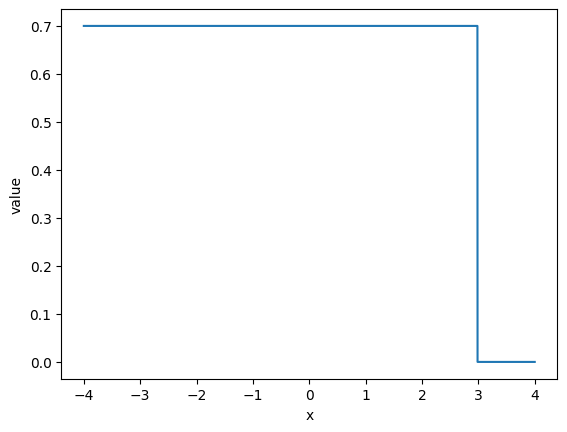

In [184]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
show_plot = 0
for t in t_array:
    if (show_plot == 50):
        ax.cla()
        data = np.zeros(x_points+1)
        for i in range(0,len(x)):
            data[i] = calculate_exact_state_1wave(waves[current_wave], x[i], t, u_hat, -4, 8/x_points, current_wave == 2)
        ax.plot(x,data)
        ax.set_xlabel('x')
        ax.set_ylabel('value')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.0001)
        show_plot = 0
    else:
        show_plot = show_plot + 1


Lets try and solve the same problem with a numerical solution using the FVM.
$$ Q_i^{n+1}=Q_i^n-\frac{\Delta t}{\Delta x}(F_{i+\frac{1}{2}}^n-F_{i-\frac{1}{2}}^n)$$

We start by setting the grid into 1000 intervals.

In [185]:
# global variables for the FVM scheme 
# interval has to be a multiple of interval_q 
n_integrals = 1000
p_in_integrals = x_points/n_integrals
delta_t = t_length/(timesteps-1)
delta_x = x_length/n_integrals
if p_in_integrals.is_integer():
    p_in_integrals = int(p_in_integrals)
else:
    print('Error: p_in_integrals is not an integer')
    sys.exit(1)
Q_0 = []
for i in range(0,n_integrals):
    Q_current = 0
    for j in range(0,p_in_integrals):
        Q_current = Q_current + waves[current_wave][i*p_in_integrals+j]
    Q_0.append(Q_current/p_in_integrals)

We do the upwind method for the advection equation:

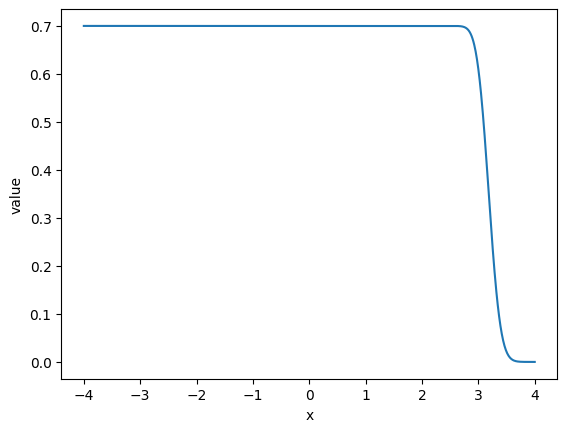

In [188]:
Q_next = np.zeros(n_integrals) 
Q_current = Q_0
show_plot = 0 # show plot every 10 timesteps
x_axis = np.linspace(-4,4,n_integrals)
for i in range(0,timesteps):
    #setting 0 instream on the left boundary
    if (current_wave == 2):
        Q_next[0] = Q_current[0]+u_hat*delta_t/delta_x*(higher_dam_break_v-Q_current[0])
    else:
        Q_next[0] = Q_current[0]+u_hat*delta_t/delta_x*(0-Q_current[0])
    for i in range(1,n_integrals):
        Q_next[i] = Q_current[i]+(u_hat*delta_t/delta_x)*(Q_current[i-1]-Q_current[i])
    Q_current = Q_next
    if (show_plot == 50):
        ax.cla()
        ax.plot(x_axis,Q_current)
        ax.set_xlabel('x')
        ax.set_ylabel('value')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.0001)
        show_plot = 0
    else:
        show_plot = show_plot + 1

In [187]:
print("CFL")
print(u_hat*delta_t/delta_x)

CFL
0.06251041840306718
